In [60]:
from typing import List, Callable

In [61]:
# seed = 1

In [75]:
import numpy as np

def ZDT1(x):
    n = len(x)  # Number of decision variables
    f1 = x[0]  # Objective 1 is just the first variable
    g = 1 + 9 * np.sum(x[1:]) / (n - 1)
    f2 = g * (1 - np.sqrt(f1 / g))  # Objective 2 formula
    return f1, f2


def ZDT2(x):
    n = len(x)  # Number of decision variables
    f1 = x[0]  # Objective 1 is just the first variable
    g = 1 + 9 * np.sum(x[1:]) / (n - 1)
    f2 = g * (1 - (f1 / g) ** 2)  # Objective 2 formula
    return f1, f2

def ZDT3(x):
    n = len(x)  # Number of decision variables
    f1 = x[0]  # Objective 1 is just the first variable
    g = 1 + 9 * np.sum(x[1:]) / (n - 1)  # g function
    h =  1 - np.sqrt(f1 / g) - (f1 / g) * np.sin(10 * np.pi * f1) # h function
    f2 = g * h  # Objective 2 formula
    return f1, f2

#TODO za zdt4 izmeniti crossover i mutation (jos nesto?)
def ZDT4(x):
    n = len(x)  # Number of decision variables
    f1 = x[0]  # Objective 1 is just the first variable
    g = 1 + 10 * (n - 1) + np.sum(x[1:]**2 - 10 * np.cos(4 * np.pi * x[1:]))  # g function
    h =  1 - np.sqrt(f1 / g) # h function
    f2 = g * h  # Objective 2 formula
    return f1, f2

def ZDT6(x):
    n = len(x)  # Number of decision variables
    f1 = 1 - np.exp(-4 * x[0]) * np.sin(6 * np.pi * x[0])**6 # Objective 1 formula
    g = 1 + 9 * (np.sum(x[1:]) / (n - 1))**0.25  # g function
    h =  1 - (f1 / g)**2 # h function
    f2 = g * h  # Objective 2 formula
    return f1, f2


In [63]:
import random

num_objectives = 2 #TODO change for different objectives
class Individual:
    """
    Individual of genetic algorithm
    code - represents one solution
    fitness - quality of the solution
    """
    def __init__(self, num_variables: int, objective_function: Callable[[np.ndarray], tuple]):
        if objective_function==ZDT4:
            self.code = np.zeros(num_variables)
            self.code[0] = np.random.uniform(0, 1)
            self.code[1:] = np.random.uniform(-5, 5, num_variables - 1) 
        else:
            self.code = np.random.uniform(0, 1, num_variables)
        self.rank = None
        self.crowding_distance = None
        self.objective_function = objective_function
        self.calc_fitness()

    def calc_fitness(self):
        self.fitness = self.objective_function(self.code)
        

In [64]:
def dominates(first_individual, second_individual):
    # todo mozda dodati toleranciju?
    is_better_in_all = True
    is_strictly_better = False

    for f1, f2 in zip(first_individual.fitness, second_individual.fitness):
        if f1 > f2:
            is_better_in_all = False
        if f1 < f2:
            is_strictly_better = True

    return is_better_in_all and is_strictly_better
    

In [65]:
def non_dominated_sorting(population: List[Individual]):
    pareto_fronts = []
    domination_count = {}  # Stores how many individuals dominate each individual
    dominated_individuals = {}  # Stores the individuals dominated by each individual
    n = len(population)
    
    for individual in population:
        domination_count[individual] = 0
        dominated_individuals[individual] = []
    
    for i in range(n):
        for j in range(n):
            if i!=j:
                if dominates(population[i],population[j]):
                    dominated_individuals[population[i]].append(population[j])
                elif dominates(population[j],population[i]):
                    domination_count[population[i]] += 1
     
    current_front = [ind for ind in population if domination_count[ind] == 0]
    current_front_index = 1
    while current_front:
        pareto_fronts.append(current_front)
        next_front = []
        for individual in current_front:
            individual.rank = current_front_index
            for dominated in dominated_individuals[individual]:
                domination_count[dominated] -= 1
                if domination_count[dominated] == 0:
                    next_front.append(dominated)
        current_front = next_front
        current_front_index += 1

    return pareto_fronts

In [66]:
from copy import deepcopy

def calculate_crowding_distance(pareto_front: List[Individual], num_objectives: int):
    n = len(pareto_front)
    # Firstly initialize every individual from front to have cd = 0
    for ind in pareto_front:
        ind.crowding_distance = 0
    for i in range(num_objectives):
        # Sort individuals based on objective
        pareto_front.sort(key = lambda x : x.fitness[i])
        pareto_front[0].crowding_distance = float('inf')
        pareto_front[-1].crowding_distance = float('inf')
        f_min = pareto_front[0].fitness[i]
        f_max = pareto_front[-1].fitness[i]
        for k in range(1,n-1):
#             assert f_max != f_min
            distance = (pareto_front[k+1].fitness[i] - pareto_front[k-1].fitness[i])/(f_max - f_min)
            pareto_front[k].crowding_distance += distance
        
    

In [67]:
def selection(population: List[Individual], k: int):
    """
    Tournament selection
    1. Choose random k individuals from the population
    2. The best of those k wins the tournament and is selected for crossover

    Primarni kriterijum za selekciju je rang. 
    Ako dve jedinke imaju isti rang, 
    preferira se ona sa većom distancom gužve.
    """
    k = min(len(population), k)
    participants = random.sample(population, k)
    
    return max(participants, key=lambda x: (-x.rank, x.crowding_distance))


In [68]:
def crossover(parent1: Individual, parent2: Individual, child1: Individual, child2: Individual, eta_c = 15):
    """
    Uniform crossover - changes children in place
    SBX
    eta_c is the distribution index for crossover
    """
    n = len(parent1.code)
    for i in range(n):
        if random.random() <= 0.5:
            u = random.random()
            if u <= 0.5:
                beta_k = (2 * u) ** (1 / (eta_c + 1))
            else:
                beta_k = (1 / (2 * (1 - u))) ** (1 / (eta_c + 1))
            child1.code[i] = 0.5 * ((1 + beta_k) * parent1.code[i] + (1 - beta_k) * parent2.code[i])
            child2.code[i] = 0.5 * ((1 - beta_k) * parent1.code[i] + (1 + beta_k) * parent2.code[i])
        else: # No crossover
            child1.code[i] = parent1.code[i]
            child2.code[i] = parent2.code[i]
        # Ensure values remain in [0,1]
        child1.code[i] = min(max(child1.code[i],0),1)
        child2.code[i] = min(max(child2.code[i],0),1)
        #TODO change for zdt4 [-5,5]
        
            
    

In [74]:
def mutation(child: Individual, p: float, eta_m = 20):
    """
    Polynomial mutation
    r - uniformly sampled random number between (0,1)
    eta_m - mutation distribution index
    """
    for i in range(len(child.code)):
        if random.random() < p:
            r = random.random()
            if r < 0.5:
                delta_q = (2 * r) ** (1 / (eta_m + 1)) - 1
            else:
                delta_q = 1 - (2 * (1 - r)) ** (1 / (eta_m + 1))
            child.code[i] += delta_q
            # ensure value remain in [0,1]
            child.code[i] = min(max(child.code[i], 0), 1)
            #TODO change for zdt4 [-5,5]

In [70]:
from matplotlib import pyplot as plt

In [71]:
def nsga2(population_size, num_variables, num_generations, 
          tournament_size, mutation_prob, elitism_size, objective_function):
    assert population_size>=2
    population = [Individual(num_variables,objective_function) 
                  for _ in range(population_size)]
    new_population = [Individual(num_variables, objective_function) 
                      for _ in range(population_size)]
    
    # (preuzeto sa vezbi)
    # parity of elitism_size and population_size must be the same
    # since we are going two by two in the inner loop
    if elitism_size % 2 != population_size % 2:
        elitism_size += 1
        
    pareto_fronts = non_dominated_sorting(population)
    for front in pareto_fronts:
        calculate_crowding_distance(front, num_objectives)
    
    for it in range(num_generations):
        population.sort(key=lambda x: (x.rank, -x.crowding_distance))
        
        new_population[:elitism_size] = population[:elitism_size]
        for i in range(elitism_size,population_size,2):
            parent1 = selection(population, tournament_size)
            # (preuzeto sa vezbi)
            # HACK: to avoid choosing parent1 again, we temporarily set its fitness to inf
            # what if tournament_size is 1?
            tmp, parent1.fitness = parent1.fitness, float('-inf')
            parent2 = selection(population, tournament_size)
            # revert change
            parent1.fitness = tmp
            
            crossover(parent1, parent2, new_population[i], new_population[i+1])
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i+1], mutation_prob)
            
            new_population[i].calc_fitness()
            new_population[i+1].calc_fitness()
        pareto_fronts = non_dominated_sorting(new_population)
        for front in pareto_fronts:
            calculate_crowding_distance(front, num_objectives)
        population = deepcopy(new_population)
    best_individual = max(population, key=lambda x: (x.rank, -x.crowding_distance))
    
    # Plotting the final Pareto front
    final_pareto_front = pareto_fronts[0]  # The first front contains the Pareto-optimal solutions
    pareto_f1_values = [ind.fitness[0] for ind in final_pareto_front]
    pareto_f2_values = [ind.fitness[1] for ind in final_pareto_front]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(pareto_f1_values, pareto_f2_values, c='red', label='Final Pareto Front')
    plt.xlabel('Objective 1 (f1)')
    plt.ylabel('Objective 2 (f2)')
    plt.title(f"Final pareto front:{objective_function.__name__}")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    

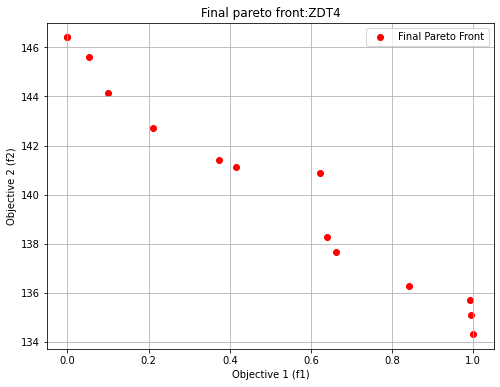

In [73]:
nsga2(population_size = 100, num_variables = 30, 
      num_generations = 200, tournament_size = 3, 
      mutation_prob = 0.1, elitism_size = 10, objective_function=ZDT4)
